<a href="https://colab.research.google.com/github/nucontreras/artificial-intelligence-scripts/blob/main/FSCN/Lineas/line_chart_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><FONT size="8" color='264653'>Audiographics Project: sonification for the accessibility of quantitative information in graphic format </FONT>

><b><FONT size="3" color='DimGray'> Sonification for the accessibility of quantitative information in graphic format is part of the research line in Technology and Care of the Millennium Institute for Care Research ([MICARE](https://www.micare.cl/)). The objective of this project is to implement a tool for the transformation of quantitative information presented in visual form into audio to facilitate access to visually handicapped people, using sonification techniques and image analysis through artificial intelligence. </FONT>

><b><FONT size="3" color='DimGray'> This file contains the processing, treatment and tests of a neural network used to filter line chart images. </FONT>

><b><FONT size="3" color='SlateGray'> Code edited from an old code made in an iPre. </FONT>

# <b><FONT size="5" color='MidnightBlue '>Connection to Google Drive </FONT>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd 'gdrive/MyDrive/AudioGraphs'

Mounted at /content/gdrive
/content/gdrive/MyDrive/AudioGraphs


#<b><FONT size="5" color='MidnightBlue '>Import of packages </FONT>



In [2]:
import os
import sys
import io
import numpy as np
from datetime import datetime
from random import shuffle, seed, randint
import time

# Data processing and visualization
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# AI models
import tensorflow as tf
from keras.utils import Sequence, plot_model
from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras import backend as K

seed(420)


from zipfile import ZipFile
%matplotlib inline

<b><FONT size="4" color='619b8a'>Path to bar chart images dataset  </FONT>

In [3]:
path_line_chart_db = 'Codigos y BD anteriores/Lineas/test_procesado/'

<b>

#<b><FONT color='MidnightBlue' size='6'>Neural network </FONT></b>

En primer lugar, se cargan datos de gráficos realizados en Python y Matlab de movimiento browniano entre 0 y 1, además de gráficos reales, tanto para el training como el testing de la red.

Posterior a esto, se define a una red convolucional-deconvolucional tal como la observada en (*Fully Symmetric Convolutional Network for Effective Image Denoising*), donde se utilizarán las capas convolucionales para extraer las características principales de la imagen ignorando aquellos elementos a eliminar, y las capas deconvolucionales para la reconstrucción de la imagen como tal.


##<b><FONT size="5" color='MidnightBlue '>Definición de la red </FONT>


In [4]:
with tf.device('/device:GPU:0'):
    input_layer = Input(shape=(256, 256, 1), name="INPUT")
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    output_layer = Conv2D(1, (3, 3), padding='same', name="OUTPUT")(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      36928 

##<b><FONT size="5" color='MidnightBlue '>Clase del DataGenerator </FONT>

In [5]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generar índices del batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Encontrar lista de IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generar Datos
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        # Actualiza los indices para cada epoch
        # Tiene el shuffle en caso de que se active
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Inicialización de datos
        # X e y son de igual dimensión ya que ambos son imágenes
        # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generación de data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = tf.keras.utils.load_img(ID, target_size=(256, 256), color_mode="grayscale", interpolation="bicubic")

            img = tf.keras.utils.img_to_array(img)
            X[i,] = (img-img.min())/(img.max() - img.min())

            # Store class
            new_ID = ID.replace("full", "solo")
            img = tf.keras.utils.load_img(new_ID, target_size=(256, 256), color_mode="grayscale", interpolation="bicubic")

            img = tf.keras.utils.img_to_array(img)

            y[i,] = (img-img.min())/(img.max() - img.min())

        return X, y

##<b><FONT size="5" color='MidnightBlue '>Generación de lista de IDs </FONT>

In [6]:
# GENERACION IDS para training y testing
IDs_train = []
IDs_test = []

for op in range(1,2):
    if op == 1:
        train_full_path = path_line_chart_db + 'python/train/graficos-full/'
        test_full_path = path_line_chart_db + 'python/test/graficos-full/'
    elif op == 2:
        train_full_path = path_line_chart_db + 'matlab/train/graficos-full/'
        test_full_path = path_line_chart_db + 'matlab/test/graficos-full/'
    elif op == 3:
        train_full_path = path_line_chart_db + 'real_new/train/graficos-full/'
        test_full_path = path_line_chart_db + 'real_new/test/graficos-full/'

    for filename in os.listdir(train_full_path):
        # Temporary solution for ._ problem
        if '._' not in filename:
            IDs_train.append(train_full_path + filename)

    for filename in os.listdir(test_full_path):
        # Temporary solution for ._ problem
        if '._' not in filename:
            IDs_test.append(test_full_path + filename)

FileNotFoundError: ignored

##<b><FONT size="5" color='MidnightBlue '>Training </FONT>

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

# Parameters
params = {'dim': (256, 256),
          'batch_size': 32,
          'n_channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(IDs_train, **params)
test_generator = DataGenerator(IDs_test, **params)

with tf.device('/device:GPU:0'):
    history = model.fit(training_generator,
                    steps_per_epoch=len(training_generator),
                    epochs=150,
                    shuffle=True, callbacks=[es])
    #history = model.fit(X_train, Y_train,
    #                batch_size = 32,
    #                epochs=30,
    #                shuffle=True) # callbacks=[es]

loss = history.history['loss']

In [ ]:
model.save('/content/drive/My Drive/iPre_Graficos/modelos/final_2.h5')

In [ ]:
# summarize history for loss
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=300,
)

In [ ]:
rec_test = model.predict(test_generator)

##<b><FONT size="5" color='MidnightBlue '>Testing </FONT>

In [ ]:
def minmax(img):
    img = ((img - img.min())/(img.max() - img.min())) #MIN MAX
    return img

def onepixel_img(img):
    onepix = np.ones(img.shape)
    for i in range(img.shape[1]):
        positions = np.where(img[:,i] == 1)
        if len(positions[0]) >= 1:
            onepix[int(np.sum(positions[0])/len(positions[0])), i] = 0
    return onepix


def show_data(model_path, img_path):
    model = load_model(model_path) # CARGADO DEL MODELO
    # IMG EN NP ARRAY (1, 256, 256, 1)
    full_img = []
    img = tf.keras.utils.load_img(img_path, color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img)
    final_shape = img.shape
    img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode = "grayscale", interpolation="bicubic")
    img = tf.keras.utils.img_to_array(img)
    img = minmax(img)
    full_img.append(img)
    full_img = np.array(full_img)
    # PREDICCION
    pred = model.predict(full_img)
    # NORMALIZACIÓN
    pred = ((pred - pred.min())/(pred.max() - pred.min()))

    # THRESHOLD
    _, thresh = cv2.threshold(pred[0,:,:,0], 0.5, 1, cv2.THRESH_BINARY_INV)
    #print(thresh.shape)
    #thresh = thresh[1].reshape(256,256)

    # ERODE-DILATE
    kernel = np.ones((3,3), np.uint8)
    kernel2 = np.ones((4,4), np.uint8)
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    dilate = cv2.dilate(erosion, kernel, iterations = 1)
    #open = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    open = cv2.erode(thresh, kernel, iterations = 0)
    open = cv2.dilate(thresh, kernel, iterations = 1)

    full_img = full_img.reshape((256,256))
    pred = pred.reshape((256,256))
    open = open.reshape((256,256))
    thresh = thresh.reshape((256,256))
    num_labels, labels_im = cv2.connectedComponents(np.uint8(open), connectivity = 8)
    a = np.bincount(labels_im.flatten())[1:]
    #print(a)
    best_a = [i+1 for i,j in enumerate(a) if j >= 0.1*a.max()]
    new = labels_im.copy()
    #print(best_a)
    for i in best_a:
        new[labels_im == i] = 9999
    new[new != 9999] = 0
    new = new/9999
    #new = minmax(new)
    #print(np.uint8(open).max())

    new = cv2.erode(new, kernel, iterations = 0)

    thresh = cv2.resize(thresh, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_NEAREST)
    pred = cv2.resize(pred, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_CUBIC)
    full_img = cv2.resize(full_img, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_CUBIC)
    open = cv2.resize(open, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_CUBIC)
    new = cv2.resize(new, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_NEAREST)


    #thresh = minmax(thresh)
    pred = minmax(pred)
    full_img = minmax(full_img)
    open = minmax(open)

    # ONE PIXEL SOLO IMG
    img_solo_path = img_path.replace("full","solo")
    img_solo = tf.keras.utils.load_img(img_solo_path, color_mode = "grayscale")
    img_solo = np.array(img_solo)
    img_solo = minmax(img_solo)
    _, img_solo = cv2.threshold(img_solo, 0.9, 1, cv2.THRESH_BINARY_INV)

    # CALCULAR DIFERENCIA VALORES REAL VS PRED

    onepix = onepixel_img(new)
    a, b = np.where(onepix == 0)
    a = np.take_along_axis(a, np.argsort(b), axis=0)
    b = np.take_along_axis(b, np.argsort(b), axis=0)
    onepix_copy = onepix.copy()
    for i in range(0, len(a) - 1):
        dy = a[i+1] - a[i]
        dx = b[i+1] - b[i]
        if abs(dy) > 1:
            delta_y = np.linspace(0,dy,abs(dy), dtype='int16')
        if int(dx) == 1:
            delta_x = np.linspace(0,1,abs(dy))
            for k in range(abs(dy)):
                if delta_x[k] < 0.5:
                    delta_x[k] = 0
                else:
                    delta_x[k] = 1
        else:
            delta_x = np.linspace(0,dx,abs(dy), dtype = 'int16')
        for j in range(1, abs(dy)):
            onepix_copy[a[i] + int(delta_y[j]), b[i] + int(delta_x[j])] = 0

    #for i in range(0, len(a) - 1):
    #  posiciones = np.where(onepix[:,b[i] + 1] == 0)
    #  if len(posiciones[0]) == 0:
    #    delta_x = b[i+1] - b[i]
    #    delta_y = a[i+1] - a[i]
    #    delta_y = np.linspace(0,delta_y,delta_x, dtype='int8')
        #print(delta_y)
        #print(delta_x, delta_y)
    #    for j in range(1, delta_x):
    #      onepix_copy[a[i] + delta_y[j], b[i] + j] = 0
    #DISPLAY
    plt.figure(figsize=(15, 15))
    plt.gray()
    ax = plt.subplot(2,2,1)
    plt.imshow(full_img)
    ax = plt.subplot(2,2,2)
    plt.imshow(1-new)
    ax = plt.subplot(2,2,3)
    plt.imshow(onepix_copy)
    ax = plt.subplot(2,2,4)
    plt.imshow(1-img_solo)


In [ ]:
# model_path = '/content/drive/My Drive/iPre_Graficos/modelos/test_gen_minmax_full_fix_16layer.h5'
model_path = '/content/drive/My Drive/iPre_Graficos/modelos/final_1.h5'
# model_path = '/content/last.h5'
#model_path = '/content/drive/My Drive/iPre_Graficos/modelos/test_gen_minmax_full_fix2.h5'
# img_path = "/content/real_new/test/graficos-full/grafico-1.png"
img_path = "/content/matlab/test/graficos-full/grafico-4010.png"
#img_path = '/content/descarga.jpg'
show_data(model_path, img_path)

In [ ]:
def minmax(img):
    img = ((img - img.min())/(img.max() - img.min())) #MIN MAX
    return img

def onepixel_img(img):
    onepix = np.ones(img.shape)
    for i in range(img.shape[1]):
        positions = np.where(img[:,i] == 1)
        if len(positions[0]) >= 1:
            onepix[int(np.sum(positions[0])/len(positions[0])), i] = 0
    return onepix

model_path = '/content/drive/My Drive/iPre_Graficos/modelos/final_1.h5'
model = load_model(model_path) # CARGADO DEL MODELO

img_path = "/content/matlab/test/graficos-full/"

for filename in os.listdir(img_path):
    # IMG EN NP ARRAY (1, 256, 256, 1)
    full_img = []
    img = tf.keras.utils.load_img(img_path + filename, color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img)
    final_shape = img.shape
    img = tf.keras.utils.load_img(img_path + filename, target_size=(256,256), color_mode = "grayscale", interpolation="bicubic")
    img = tf.keras.utils.img_to_array(img)
    img = minmax(img)
    full_img.append(img)
    full_img = np.array(full_img)
    # PREDICCION
    pred = model.predict(full_img)
    # NORMALIZACIÓN
    pred = ((pred - pred.min())/(pred.max() - pred.min()))

    # THRESHOLD
    _, thresh = cv2.threshold(pred[0,:,:,0], 0.5, 1, cv2.THRESH_BINARY_INV)

    # ERODE-DILATE
    kernel = np.ones((3,3), np.uint8)
    open = cv2.dilate(thresh, kernel, iterations = 1)

    full_img = full_img.reshape((256,256))
    pred = pred.reshape((256,256))
    open = open.reshape((256,256))
    thresh = thresh.reshape((256,256))
    num_labels, labels_im = cv2.connectedComponents(np.uint8(open), connectivity = 8)
    a = np.bincount(labels_im.flatten())[1:]
    best_a = [i+1 for i,j in enumerate(a) if j >= 0.1*a.max()]
    new = labels_im.copy()
    for i in best_a:
        new[labels_im == i] = 9999
    new[new != 9999] = 0
    new = new/9999

    thresh = cv2.resize(thresh, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_NEAREST)
    pred = cv2.resize(pred, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_CUBIC)
    full_img = cv2.resize(full_img, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_CUBIC)
    open = cv2.resize(open, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_CUBIC)
    new = cv2.resize(new, (final_shape[1], final_shape[0]), interpolation = cv2.INTER_NEAREST)

    # CALCULAR DIFERENCIA VALORES REAL VS PRED
    onepix = onepixel_img(new)
    a, b = np.where(onepix == 0)
    a = np.take_along_axis(a, np.argsort(b), axis=0)
    b = np.take_along_axis(b, np.argsort(b), axis=0)
    onepix_copy = onepix.copy()
    for i in range(0, len(a) - 1):
        dy = a[i+1] - a[i]
        dx = b[i+1] - b[i]
        if abs(dy) > 1:
            delta_y = np.linspace(0,dy,abs(dy), dtype='int16')
        if int(dx) == 1:
            delta_x = np.linspace(0,1,abs(dy))
            for k in range(abs(dy)):
                if delta_x[k] < 0.5:
                    delta_x[k] = 0
                else:
                    delta_x[k] = 1
        else:
            delta_x = np.linspace(0,dx,abs(dy), dtype = 'int16')
        for j in range(1, abs(dy)):
            onepix_copy[a[i] + int(delta_y[j]), b[i] + int(delta_x[j])] = 0

    # GUARDAR ARCHIVO PRED, OUT, OUT_ONEPIXEL
    dir = f"/content/matlab/pred/{filename}"
    im = Image.fromarray(255*pred)
    im = im.convert("L")
    im.save(dir)
    dir = f"/content/matlab/out/{filename}"
    im = Image.fromarray(255*(1-new))
    im = im.convert("L")
    im.save(dir)
    dir = f"/content/matlab/out_onepixel/{filename}"
    im = Image.fromarray(255*onepix_copy)
    im = im.convert("L")
    im.save(dir)



In [ ]:
!zip -r /content/python.zip /content/python

In [ ]:
from google.colab import files
files.download("/content/python.zip")

In [ ]:
img = tf.keras.utils.load_img("/content/matlab/test/graficos-full/grafico-4017.png", color_mode = "grayscale")
img2 = tf.keras.utils.load_img("/content/matlab/test/graficos-full/grafico-4017.png", target_size = (256,256), color_mode = "grayscale", interpolation = "bicubic")
shape = np.array(img).shape
print(np.array(img2).shape)
#img = cv2.resize(np.array(img), (256,256), interpolation = cv2.INTER_CUBIC)
img2 = cv2.resize(np.array(img2), (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
print(img2.shape)
plt.imshow(img2)

##<b><FONT size="5" color='MidnightBlue '>Capa a Capa </FONT>

In [ ]:
#REVISAR CADA CAPA

img_path = "/content/python/train/graficos-full/grafico-36.png"
full_img = []
img = tf.keras.utils.load_img(img_path, target_size=(256, 256), color_mode = "grayscale")
img = tf.keras.utils.img_to_array(img)
img = ((img - img.min())/(img.max() - img.min())) #MIN MAX
full_img.append(img)
full_img = np.array(full_img)

# N° CAPA
n = 10
get_layer_output = K.function([model.layers[0].input], [model.layers[n].output])

layer_output = get_layer_output([full_img])[0]
print(layer_output.shape)
plt.figure(figsize = (30,30))
plt.gray()
if n != 0 and n != 11:
    for i in range(64):
        plt.subplot(8,8,(i+1))
        plt.imshow(layer_output[0,:,:,i])
        plt.axis(False)
else:
    plt.figure(figsize = (10,10))
    plt.imshow(layer_output[0,:,:,0])
    plt.axis(False)

<b>

# <b><FONT size="7" color='MidnightBlue '>Annexes </FONT>


In [ ]:
def BM(dt):
    T = np.arange(0, 1 + dt, dt)
    n = len(T)
    B = np.ones(n) * 0
    for i in range(n):
        xi = np.sqrt(2) * (np.random.randn()) / ((i+0.5) * np.pi)
        B = B + xi * np.array([np.sin((i + 0.5) * np.pi * t) for t in T])
    return T, B

IndexError: ignored

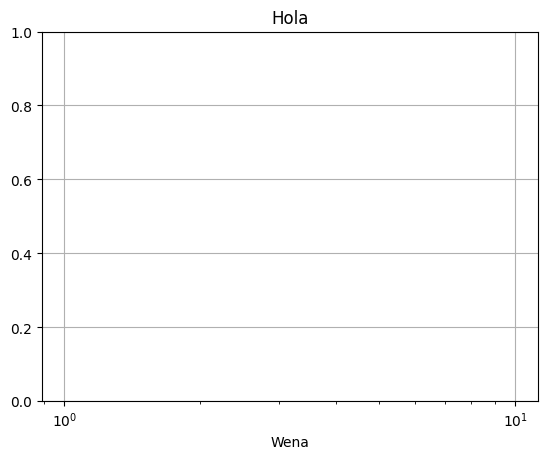

In [ ]:
#CREAR GRAFICO DE CUALQUIER COSA (?)
n_points = 100
#y = np.zeros((n_points,1))
x = np.arange(0,n_points)
#for i in range(n_points):
y = BM(1/n_points)[1]
y = y[1:]
fig = plt.figure()
#plt.ylim(-10,10) # FIJAR EL LIMITE
plt.title("Hola")
plt.xlabel("Wena")
plt.grid()
plt.xscale("log")
n = randint(0,n_points)
plt.text(x[n],0,"Algo", fontsize = 14)
plt.plot(x,y)

In [ ]:
# GRAFICAR Y GUARDAR

# https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
# define a function which returns an image as numpy array from figure
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
    return img

# MOVIMIENTO BROWNIANO
# http://cienciactuarial.blogspot.com/2017/12/simulacion-de-movimiento-browniano-con.html

def BM(dt):
    T = np.arange(0, 1 + dt, dt)
    n = len(T)
    B = np.ones(n) * 0
    for i in range(n):
        xi = np.sqrt(2) * (np.random.randn()) / ((i + 0.5) * np.pi)
        B = B + xi * np.array([np.sin((i + 0.5) * np.pi * t) for t in T])
    return T, B

In [ ]:
# CREACIÓN DE IMÁGENES

t = time.time()

n_points = 100
counter = 0
x = np.arange(0,n_points)
zip_counter = 6
estilos = ['-','--', '-.', ':','']
locs = ['upper left', 'upper right', 'lower left', 'lower right','upper center', 'lower center', 'center left', 'center right']
titulos = ["Title", "Plots", "Curves", "Experiments", "Time vs Something"]
palabras = ["Experiment", "Wrong", "Correct", "Point", "Maximum", "Minimum", "Incorrect", "New Value", "Linear Function", "Irregular Curve"]
for ii in range(1):
    for i in range(1000):#y.shape[1]
        log = False
        y = BM(1/n_points)[1]
        y = y[1:]

        # PLOT FIGURA ENTERA
        fig = plt.figure()
        #plt.ylim(-10,10) # FIJAR EL LIMITE
        n1 = randint(0,4) # ESTILO GRILLA
        n2 = randint(0,3) # ESTILO LINEA
        #n3 = randint(0,1)
        n4 = randint(1,2) # ANCHO GRILLA
        n5 = randint(1,5) # ANCHO LINEA
        #LEYENDA
        n6 = randint(0,1) # SI HAY LEYENDA
        n7 = randint(0,len(locs)-1) # UBICACION LEYENDA
        n8 = randint(0,1) # FRAME LEYENDA
        plt.grid(linestyle = estilos[n1], linewidth = n4)
        plt.plot(x, y, linestyle = estilos[n2], linewidth=n5, label = 'Curve')
        if n6 == 1:
            plt.legend(loc = locs[n7], title = "Legend", frameon = (n8 == 1) )
        if randint(0,1) == 1:
            log = True
            plt.xscale("log")
        plt.title(titulos[randint(0,len(titulos) - 1)] , fontsize = 18)
        for k in range(5):
            if randint(0,1) == 1:
                break
            else:
                plt.text(x[randint(0,n_points - 10)], y[randint(0, n_points - 1)], palabras[randint(0, len(palabras) - 1)], fontsize = 16)
        plt.xlabel("XLABEL", fontsize = 14)
        plt.ylabel("YLABEL", fontsize = 14)


        img = get_img_from_fig(fig)
        plt.close()
        dir = f"/content/graficos-full/grafico-{str(1000*(zip_counter - 1) + i)}.png"
        cv2.imwrite(dir,img)

        # PLOT FIGURA AISLADA
        fig = plt.figure()
        plt.plot(x, y)
        plt.axis('off')
        if log:
            plt.xscale("log")
        img = get_img_from_fig(fig)
        plt.close()
        dir = f"/content/graficos-solo/grafico-{str(1000*(zip_counter - 1) +  i)}.png"
        cv2.imwrite(dir,img)

        counter += 1

        if counter == 1000:
            zipObj = ZipFile(f'/content/drive/My Drive/iPre_Graficos/graficos-full_zip_{zip_counter}.zip', 'w')
            for j in range(1000):
                zipObj.write(f'/content/graficos-full/grafico-{str(1000*(zip_counter - 1) + j)}.png')
                os.remove(f'/content/graficos-full/grafico-{str(1000*(zip_counter - 1) + j)}.png')
            zipObj.close()

            zipObj = ZipFile(f'/content/drive/My Drive/iPre_Graficos/graficos-solo_zip_{zip_counter}.zip', 'w')
            for j in range(1000):
                zipObj.write(f'/content/graficos-solo/grafico-{str(1000*(zip_counter - 1) + j)}.png')
                os.remove(f'/content/graficos-solo/grafico-{str(1000*(zip_counter - 1) + j)}.png')
            zipObj.close()

            zip_counter += 1
            counter = 0

elapsed = time.time() - t
print(f"Tiempo que se ha demorado: {elapsed} s")

<b>

### Cargado de Datos

In [ ]:
!unzip '/content/drive/My Drive/iPre_Graficos/Final/graficos_new_4.zip'

We don´t have this zip's file.

### Data Augmentation

In [ ]:
!unzip train.zip

We don´t have this zip's file.

In [ ]:
path_full = "real/train/full/"
path_solo = "real/train/solo/"
path_full_2 = "real_new/train/graficos-full/"
path_solo_2 = "real_new/train/graficos-solo/"
counter = 1
counter_2 = 1
for i in range(1, 40):
    # PRIMERO
    im = Image.open(path_full+str(i)+'.png')
    im.save(f"{path_full_2}grafico-{str(1 + (counter_2 - 1)*6)}.png", quality=95)
    im_solo = Image.open(path_solo+"grafico-"+str(1 + (counter_2 - 1)*5)+".png")
    im_solo.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    # ROTATE
    counter += 1
    ang = randint(1,360)
    im_rotate = im.rotate(ang, expand=True)
    im_solo_rotate = im_solo.rotate(ang, expand=True)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # ROTATE
    ang = randint(1,360)
    im_rotate = im.rotate(ang, expand=True)
    im_solo_rotate = im_solo.rotate(ang, expand=True)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # ROTATE
    ang = randint(1,360)
    im_rotate = im.rotate(ang, expand=True)
    im_solo_rotate = im_solo.rotate(ang, expand=True)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # FLIP
    im_rotate = ImageOps.flip(im)
    im_solo_rotate = ImageOps.flip(im_solo)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # MIRROR
    im_rotate = ImageOps.mirror(im)
    im_solo_rotate = ImageOps.mirror(im_solo)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    counter_2 += 1



In [ ]:
path_full = "real/test/full/"
path_solo = "real/test/solo/"
path_full_2 = "real_new/test/graficos-full/"
path_solo_2 = "real_new/test/graficos-solo/"
counter = 1
counter_2 = 1
for i in range(40,50):
    #PRIMERO
    im = Image.open(path_full+str(i)+'.png')
    im.save(f"{path_full_2}grafico-{str(1 + (counter_2 - 1)*6)}.png", quality=95)
    im_solo = Image.open(path_solo+str(i)+".png")
    im_solo.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    # ROTATE
    counter += 1
    ang = randint(1,360)
    im_rotate = im.rotate(ang, expand=True)
    im_solo_rotate = im_solo.rotate(ang, expand=True)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # ROTATE
    ang = randint(1,360)
    im_rotate = im.rotate(ang, expand=True)
    im_solo_rotate = im_solo.rotate(ang, expand=True)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # ROTATE
    ang = randint(1,360)
    im_rotate = im.rotate(ang, expand=True)
    im_solo_rotate = im_solo.rotate(ang, expand=True)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # FLIP
    im_rotate = ImageOps.flip(im)
    im_solo_rotate = ImageOps.flip(im_solo)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    # MIRROR
    im_rotate = ImageOps.mirror(im)
    im_solo_rotate = ImageOps.mirror(im_solo)
    im_rotate.save(f"{path_full_2}grafico-{counter}.png", quality=95)
    im_solo_rotate.save(f"{path_solo_2}grafico-{counter}.png", quality=95)
    counter += 1
    counter_2 += 1

In [ ]:
!zip -r "/content/drive/My Drive/iPre_Graficos/Final/real_new.zip" "/content/real_new/"